# 2D Preprocessing the GlobColour Dataset 
* prepare dataset for LDS-fitting:
   * load all 5 variables and merge (interpolate) with the float dataset
   * load the distance to coast and merge (interpolate) with the float dataset
   * output the data on disk
   * (plan)if needed, split Nov-Dec, encoding the weekly number

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [58]:
# resampling frequency in number of days
freq=15

In [3]:
from tools.load_GlobColor_dataset import load_dataset
import importlib
importlib.reload(load_dataset)

<module 'tools.load_GlobColor_dataset.load_dataset' from '/Users/vyan2000/work_linux/2Archive/myproject/20161024xray_oceancolor/ocean_color-master/tools/load_GlobColor_dataset/load_dataset.py'>

In [5]:
############### PAR
# ulimit, .DS_Store
ds_daily = load_dataset.load_par()


100%|██████████| 5497/5497 [01:05<00:00, 84.03it/s] 


<xarray.Dataset>
Dimensions:   (lat: 553, lon: 721, time: 5497)
Coordinates:
  * lat       (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon       (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time      (time) datetime64[ns] 2002-06-23 2002-06-24 2002-06-25 ...
Data variables:
    PAR_mean  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.4
    title:                      GlobColour daily merged MODIS/SeaWiFS product
    product_name:               L3m_20020623__665648402_4_AVW-MODSWF_PAR_DAY_...
    product_type:               day
    product_version:            2016.1
    product_level:              3
    parameter_code:             PAR
    parameter:                  Photosynthetically Available Radiation
    parameter_algo_list:        ,
    publication:                http://oceancolor.gsfc.nasa.gov/DOCS/seawifs_...
    site_name:                  665648402
    sensor_n

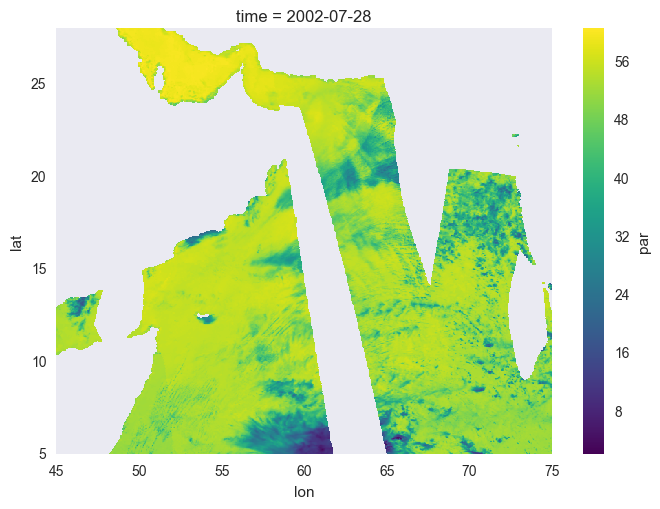

In [6]:
ds_daily.par.sel(time='2002-07-28').plot()

In [7]:
freq_resample = str(8) + 'D'
ds_8day = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_8day

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 688)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-06-23 2002-07-01 2002-07-09 ...
Data variables:
    par      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [8]:
# check data quality
both_datasets = [ds_8day, ds_daily]
print([(ds.nbytes / 1e6) for ds in both_datasets])

[2194.526952, 17533.85196]


In [9]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are par values less than zero
    bad_data = ds.par.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.par[n].values 
        ds.par.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [10]:
[fix_bad_data(ds) for ds in both_datasets]

[None, None]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


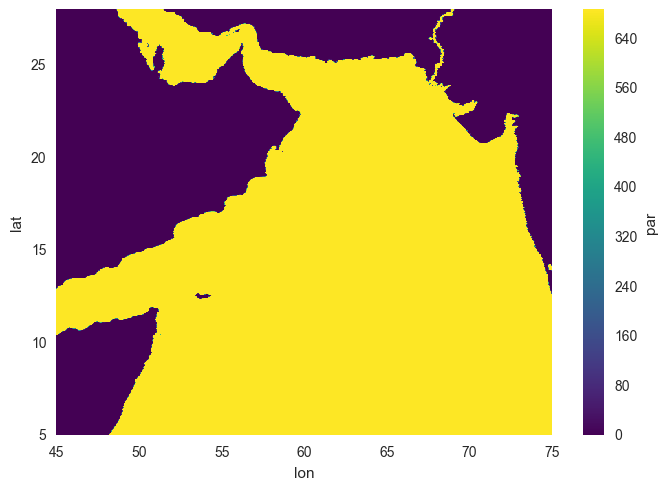

In [11]:
# Count the number of ocean data points
(ds_8day.par>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


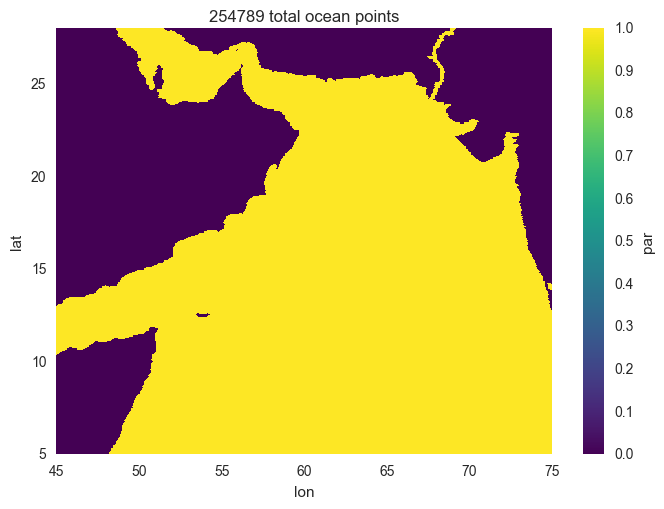

In [12]:
#  find a mask for the land
ocean_mask = (ds_8day.par>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


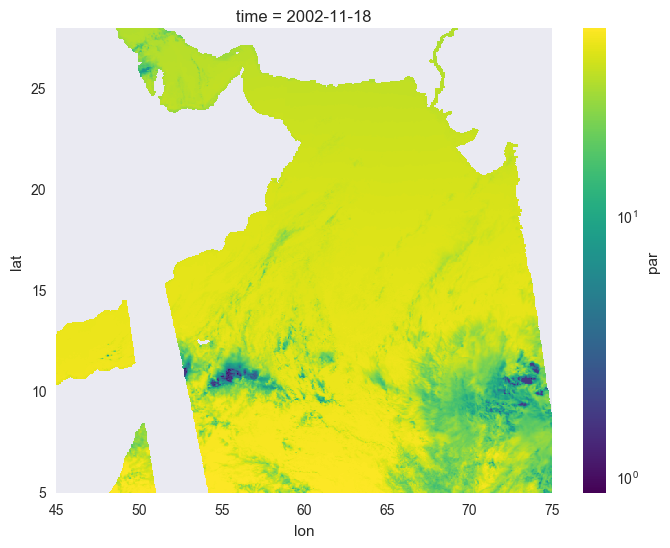

In [13]:
plt.figure(figsize=(8,6))
ds_daily.par.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())

In [14]:
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5497)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-23 2002-06-24 2002-06-25 ...
Data variables:
    par      (time) int64 107944 109378 112342 123008 126913 108553 118144 ...

In [15]:
ds_daily.par.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'par' (time: 5497)>
array([ 0.42366 ,  0.429289,  0.440922, ...,  0.904439,  0.986063,  0.744805])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-23 2002-06-24 2002-06-25 ...

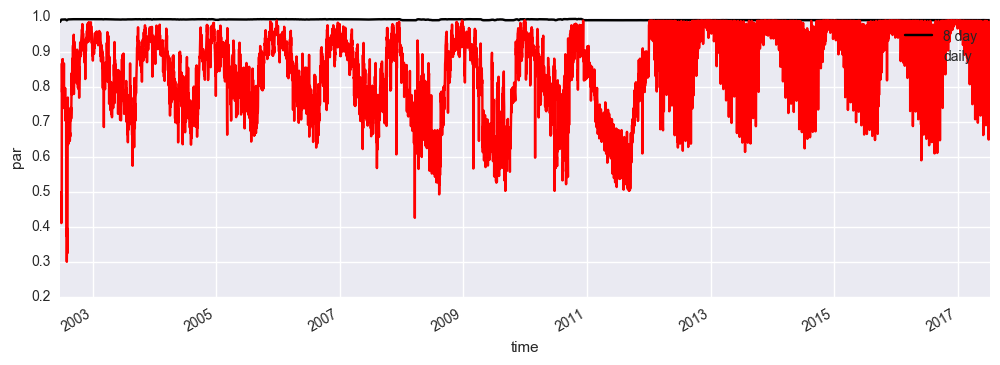

In [16]:
count_8day,count_daily = [ds.par.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


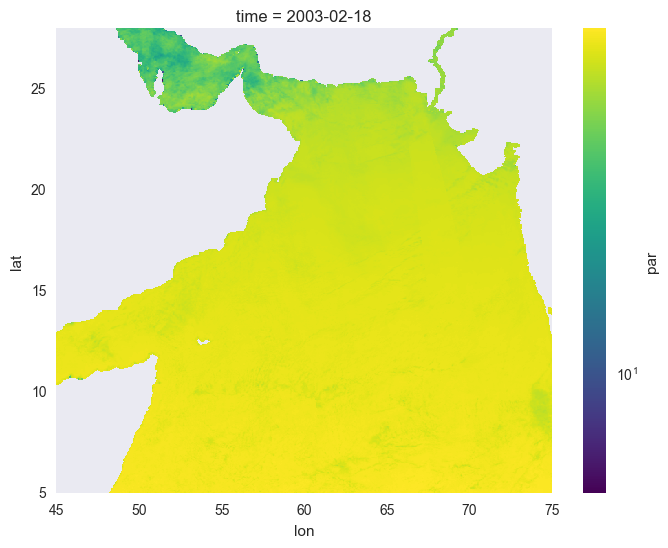

In [17]:
# Maps of individual days
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.par.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


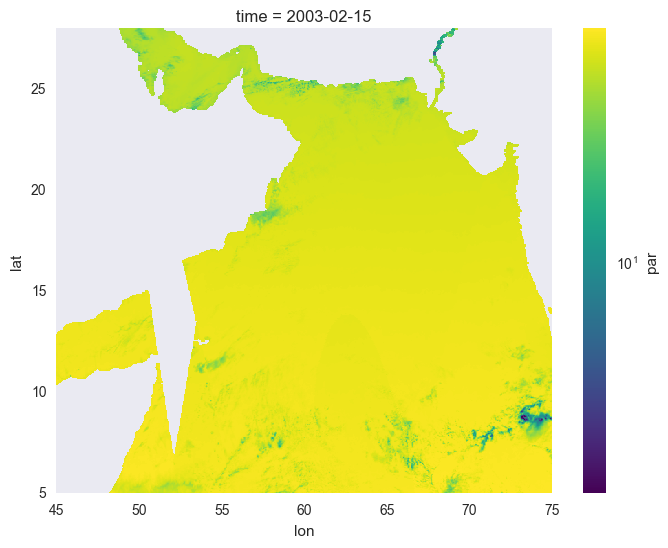

In [18]:
plt.figure(figsize=(8,6))
ds_daily.par.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [59]:
freq

15

In [60]:
# next carry out interpolation starts here
freq_resample = str(freq) + 'D'
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 367)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-06-23 2002-07-08 2002-07-23 ...
Data variables:
    par      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


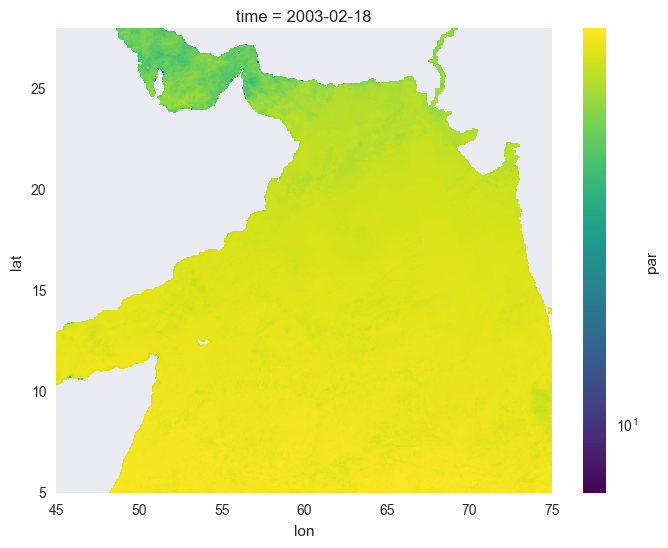

In [61]:
plt.figure(figsize=(8,6))
ds_resample.par.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [62]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(44.97917175292969) 
 <xarray.DataArray 'lat' ()>
array(5.020830154418945)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [63]:
# load preprocessed float data, and start the interpolation right here!!!!
var4 = "t865"
var3 = "kd490"
var2 = "cdm"
var1 = "chl"
vardist = "dist"
indir_prefix = "./data_globcolour/output.data.interpolate/" + "df_Globcolor_"
indir = indir_prefix + var1 + vardist + var2 + var3 + var4 + "_" + str(freq) + "d.csv"

floatDF_tmp = pd.read_csv(indir,index_col=0)
print(floatDF_tmp)

              id        time        lat        lon       temp         ve  \
366        10206  2002-07-04  16.265717  66.663800        NaN   6.140233   
732        10208  2002-07-04  13.549633  70.195217        NaN  11.373300   
1098       11089  2002-07-04  15.657150  65.248067  27.773283   9.376883   
1464       15703  2002-07-04  13.611350  70.165200  28.590333  10.194983   
2196       27069  2002-07-04  19.969700  70.048350  28.916267  25.855350   
2928       28842  2002-07-04  18.350883  60.961600  27.226833   5.825783   
3294       34159  2002-07-04  13.394633  60.516650        NaN  31.603317   
4026       34210  2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4392       34211  2002-07-04   7.797533  69.070367  28.430017  19.858683   
4758       34212  2002-07-04   6.519433  66.877317  28.568833  34.703000   
5490       34310  2002-07-04   5.023286  70.029000  28.954857   8.074714   
5856       34311  2002-07-04   9.730864  69.980455  28.593818  -2.896714   
6222       3

In [64]:
from tools.time_lat_lon_interpolate import interpolate
importlib.reload(interpolate)


result_out5 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, floatDF_tmp, dims = 'points', col_name ='par')
print('\n *** after the interpolation *** \n', result_out5)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(floatDF_tmp.index), len(result_out5.index) ) )  


 *** after the interpolation *** 
               id        time        lat        lon       temp         ve  \
366        10206  2002-07-04  16.265717  66.663800        NaN   6.140233   
732        10208  2002-07-04  13.549633  70.195217        NaN  11.373300   
1098       11089  2002-07-04  15.657150  65.248067  27.773283   9.376883   
1464       15703  2002-07-04  13.611350  70.165200  28.590333  10.194983   
2196       27069  2002-07-04  19.969700  70.048350  28.916267  25.855350   
2928       28842  2002-07-04  18.350883  60.961600  27.226833   5.825783   
3294       34159  2002-07-04  13.394633  60.516650        NaN  31.603317   
4026       34210  2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4392       34211  2002-07-04   7.797533  69.070367  28.430017  19.858683   
4758       34212  2002-07-04   6.519433  66.877317  28.568833  34.703000   
5490       34310  2002-07-04   5.023286  70.029000  28.954857   8.074714   
5856       34311  2002-07-04   9.730864  69.980455  

              id        time        lat        lon       temp         ve  \
366        10206  2002-07-04  16.265717  66.663800        NaN   6.140233   
732        10208  2002-07-04  13.549633  70.195217        NaN  11.373300   
1098       11089  2002-07-04  15.657150  65.248067  27.773283   9.376883   
1464       15703  2002-07-04  13.611350  70.165200  28.590333  10.194983   
2196       27069  2002-07-04  19.969700  70.048350  28.916267  25.855350   
2928       28842  2002-07-04  18.350883  60.961600  27.226833   5.825783   
3294       34159  2002-07-04  13.394633  60.516650        NaN  31.603317   
4026       34210  2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4392       34211  2002-07-04   7.797533  69.070367  28.430017  19.858683   
4758       34212  2002-07-04   6.519433  66.877317  28.568833  34.703000   
5490       34310  2002-07-04   5.023286  70.029000  28.954857   8.074714   
5856       34311  2002-07-04   9.730864  69.980455  28.593818  -2.896714   
6222       3

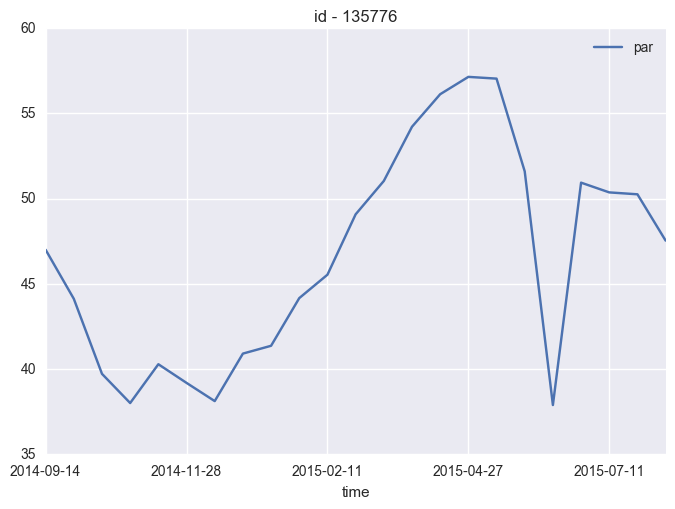

In [65]:
# output the dataframe result_out4
var5 = "par"
outdir_prefix = "./data_globcolour/output.data.interpolate/" + "df_Globcolor_"
outdir = outdir_prefix + var1 + vardist + var2 + var3 + var4 + var5 + "_" + str(freq) + "d.csv"
result_out5.to_csv(outdir)
print(pd.read_csv(outdir,index_col=0))

### plot for id 125776, which will be fit by LDS
plt.figure(figsize=(8,6))
result_out5[result_out5.id == 135776].plot(x='time', y ='par', title=('id - %d' % 135776) )
plt.show();
plt.close("all")